In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import sqlite3
import rubin_sim
import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import SkyAreaGenerator
from rubin_sim.data import get_baseline
rubin_sim.__version__
import meanz_modules as mzmod
import scipy
import sklearn

In [2]:
from os import path
opsim_fname = rubin_sim.data.get_baseline()
run_name = path.splitext(path.basename(opsim_fname))[0]
nside=64

In [87]:
import importlib
importlib.reload(mzmod)

<module 'meanz_modules' from '/pscratch/sd/r/rmandelb/ObsStrat/code/meanz_uniformity/meanz_modules.py'>

# Acquiring a dataset

We begin by getting a dataset that is useful for exploring an "area at risk" metric.  As a reminder, the idea behind this metric is that it will assume that we are unable to fully address the depth inhomogeneities induced by rolling (in particular due to the spatial structure generating large-scale power) so we will instead apply some draconian area cuts to get a catalog that has much less large-scale power in the depth maps and other quantities that generate systematics.  We have a 3x2pt FoM metric already in MAF, and it takes a depth and area as inputs -- so as long as we can identify the potential area loss due to rolling, we can use the FoM metric for the full area vs. the horribly cut area to make a metric quantifying scientific losses.

The focus of this notebook, therefore, is on how to actually define the area that is at risk.

We'd like to begin with a case that we know is problematic, so we can ensure our metric captures it.  To that end, we start with the RIZ coadded exposure time after 3 years (cumulative), as we know that in the baseline strategy that is the maximally inhomogeneous year, and exposure time will look more extreme than depth (which helps us better identify contiguous segments of survey associated with rolling).

We'll do this both for baseline and noroll (as a comparison).  We start with baseline; the plots below show the exposure time map and the 1D histogram of cumulative RIZ exposure times.  Then we get the same for noroll.

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


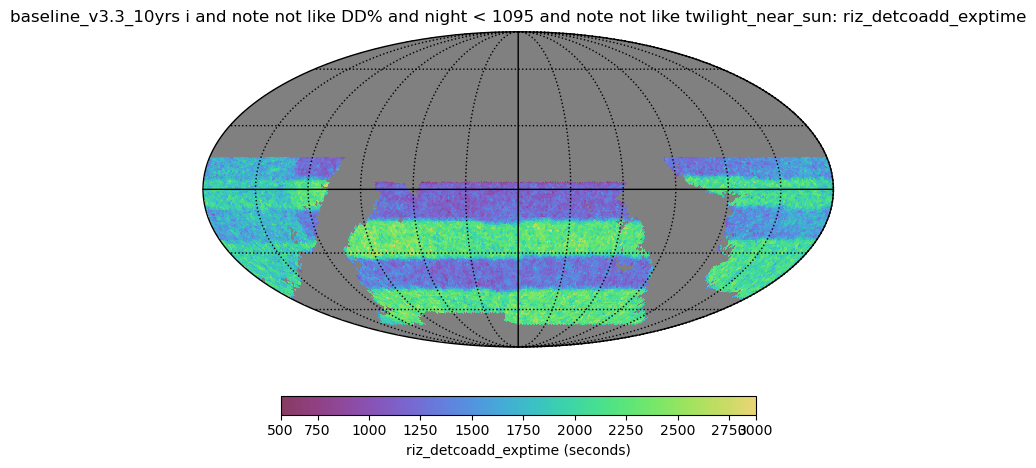

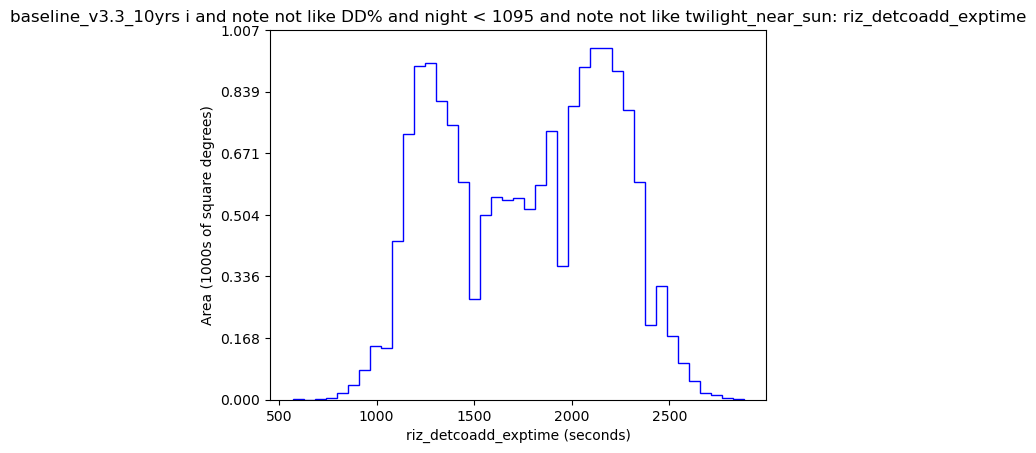

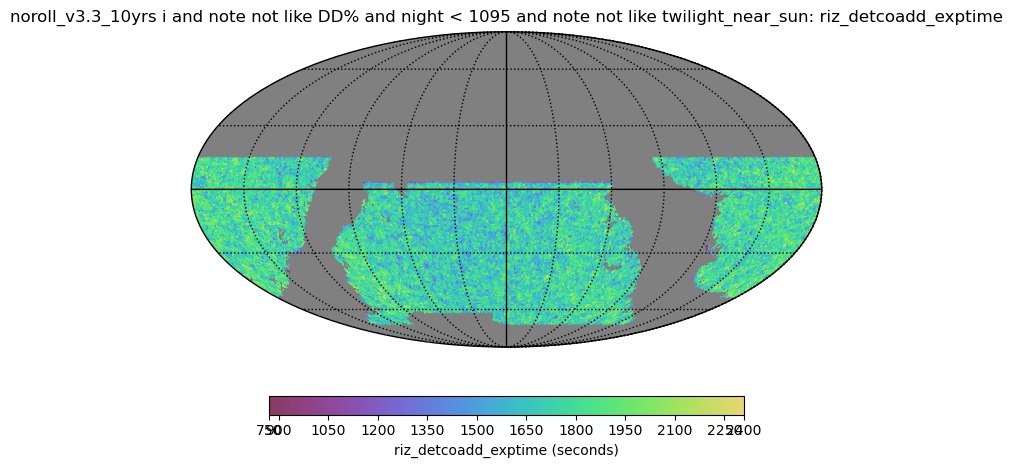

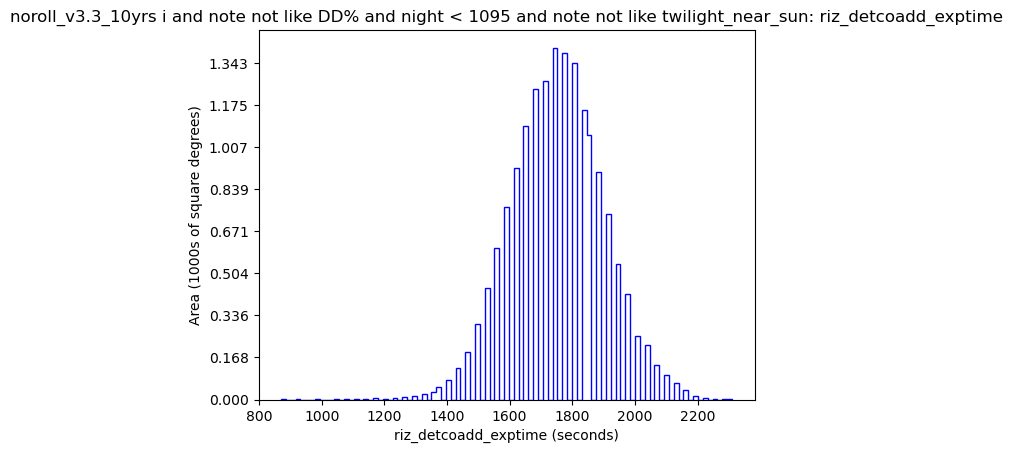

In [4]:
v33_sim_list = ['/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db',
               '/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db']
v33_name_list = [path.splitext(path.basename(sim))[0] for sim in v33_sim_list]
outmaps = {}

for i in range(len(v33_sim_list)):
    bgroup, bd, outmaps[v33_name_list[i]] = mzmod.metric_plots(v33_name_list[i], v33_sim_list[i], use_metric=maf.RIZDetectionCoaddExposureTime(), 
                                                               year=3, nside=nside, return_map=True)
    bgroup.plot_all(closefigs=False)

# Diagnostic plots

The above plots were separately constructed for each strategy.  We'd like a fair comparison, as that might help us move towards a way of defining "area at risk".  Let's begin with the 1D PDF of cumulative exposure times, using a common set of bins.

Text(0.5, 0, 'RIZ cumulative exposure time')

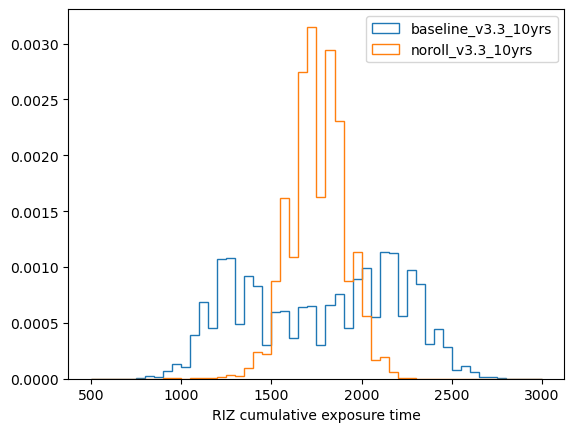

In [5]:
# Define a set of histogram bins
min_t = 500
max_t = 3000
delta_t = 50
n_bins = (max_t-min_t)/delta_t
bins = np.linspace(min_t, max_t, int(n_bins+1))
# Define plot
fig = plt.figure()
ax = fig.add_subplot(111)
for key in outmaps.keys():
    # Get non-masked (nonzero) pixel values
    this_map = outmaps[key]
    # Make and plot histogram
    plt.hist(this_map[this_map>0.1], bins=bins, label=key, density=True, histtype='step')
plt.legend()
plt.xlabel('RIZ cumulative exposure time')

We see that the `noroll` case is more narrowly peaked as expected.  Baseline has two broad peaks above/below the peak for noroll.

While this was instructive, it would be interesting to more precisely pinpoint what rolling is doing by considering the differences _at fixed position on the sky_ -- i.e., the PDF of the _difference_ in depths.  Let's do that next, and try to model it as a sum of two Gaussians (one to model a shift towards brighter values, one to model a shift towards fainter values).

In [6]:
def double_gauss(x, *args):
    # Convenience function for fitting to a sum of Gaussians.
    m1, m2, s1, s2, k1, k2 = args
    ret = k1*scipy.stats.norm.pdf(x, loc=m1 ,scale=s1)
    ret += k2*scipy.stats.norm.pdf(x, loc=m2 ,scale=s2)
    return ret
params = [-500, 500, 200, 200, 1e-3, 1e-3]

0.0 2880.0 0.0
Best-fitting parameters: [-4.24115674e+02  3.28879567e+02  1.46812897e+02  2.75620221e+02
  4.01644724e-01  6.18932821e-01]


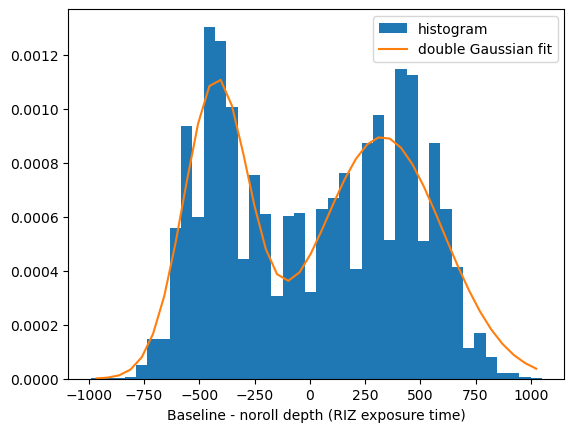

In [7]:
# Take the difference between maps
map1 = outmaps['baseline_v3.3_10yrs']
map2 = outmaps['noroll_v3.3_10yrs']
print(np.min(map1), np.max(map1), np.median(map1))
dmap = map1 - map2

# Mask differently, since 0 is now a reasonable value
dmap[map1<0.1] = -10000
dmap[map2<0.1] = -10000

# Histogram the differences
fig = plt.figure()
ax = fig.add_subplot(111)
counts, bins, _ = plt.hist(dmap[dmap>-9999], density=True, bins=40, label='histogram')
bin_mids = 0.5*(bins[1:] + bins[:-1])
plt.xlabel('Baseline - noroll depth (RIZ exposure time)')

# Fitting
fitted_params,_ = scipy.optimize.curve_fit(double_gauss, bin_mids, counts, p0=params)
plt.plot(bin_mids, double_gauss(bin_mids, *fitted_params), label='double Gaussian fit')
plt.legend()

print('Best-fitting parameters:',fitted_params)

We can see that this distribution is relatively broad and double-peaked, so it can be pretty well fit by a double Gaussian.  It has a rather surprising amount of small-scale structure.

This suggests one possible pathway to defining an "area at risk" metric: cut this distribution at the local minimum in between the peaks, and keep the larger chunk of pixels.  While they won't be exactly continguous, they will be approximately contiguous (we can of course check this directly), and it's just to give us an approximate idea anyway.

To confirm this idea, we can read off the local minimum as falling at -150.  Below is the overall map, followed by a version containing only those regions with Delta(exptime)>-150.  As shown, the regions selected are relatively contiguous.


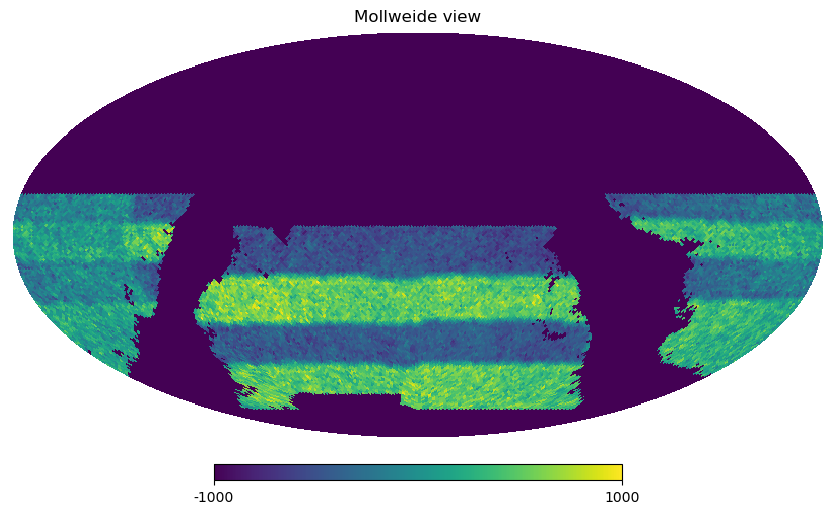

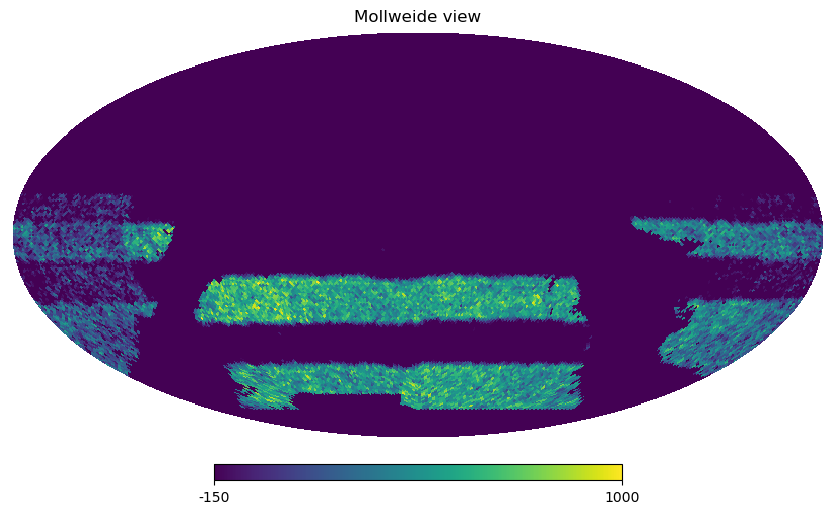

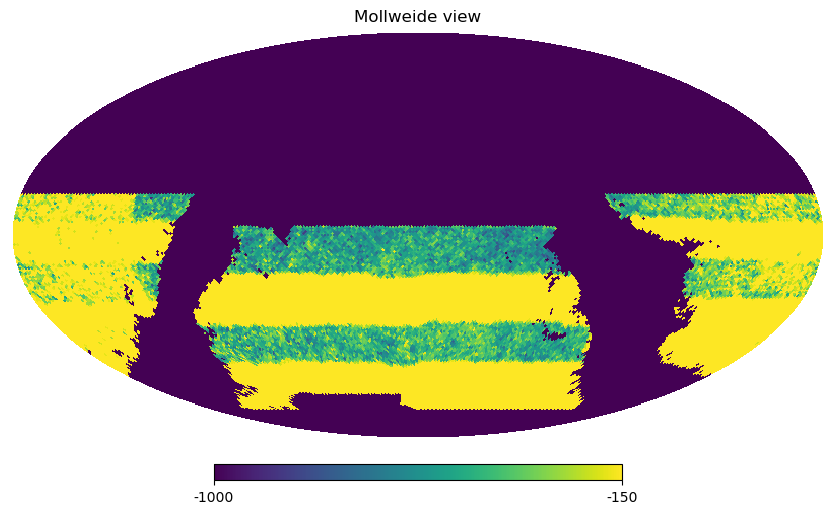

In [8]:
hp.visufunc.mollview(dmap, min=-1000, max=1000)
hp.visufunc.mollview(dmap, min=-150, max=1000)
hp.visufunc.mollview(dmap, min=-1000, max=-150)

TODO: We can also compute the total power metric to confirm that we've reduced the large-scale power with this selection.  That will be important in discussions with the SCOC: when the total distribution of depth across the survey is already ~0.5 mag wide in the `noroll` case, it's hard to argue that another few tenths of a mag is a problem.  So we have to argue on the basis that it's non-random and leads to significant large-scale power that will affect lensing/clustering measurements.

The disadvantage of this approach to defining an "area at risk" metric is that the metric will require information about multiple strategies in order to be run -- i.e., it requires information about a comparable strategy without rolling to define the area to be cut.  While we have generally been OK with our metrics being relative in their outputs (e.g., that we compare the output from baseline to the output from noroll), it could introduce significant technical complexity to require one strategy as an _input_ to computing the metric for another.  For this reason we would like to explore other options.

In [9]:
# Ignore this cell for now -- it was designed for depth maps, not exposure time maps
#total_power_baseline, ell1, cell1 = mzmod.my_total_power_metric(map1, return_functions=True)
#hp.visufunc.mollview(map1, min=24.5)
#map1_sub = map1.copy()
#map1_sub[dmap>=-0.05] = 0
#total_power_baseline_1, ell11, cell11 = mzmod.my_total_power_metric(map1_sub, return_functions=True)
#hp.visufunc.mollview(map1_sub, min=24.5)
#map1_sub = map1.copy()
#map1_sub[dmap<-0.05] = 0
#total_power_baseline_2, ell12, cell12 = mzmod.my_total_power_metric(map1_sub, return_functions=True)
#hp.visufunc.mollview(map1_sub, min=24.5)
#total_power_noroll, ell2, cell2 = mzmod.my_total_power_metric(map2, return_functions=True)

#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.plot(ell1, cell1, label='Baseline')
#ax.plot(ell11, cell11, label='Baseline chunk 1')
#ax.plot(ell12, cell12, label='Baseline chunk 2')
#ax.plot(ell2, cell2, label='Noroll')
#plt.legend()
#plt.xlabel('l')
#plt.ylabel('C_l')
#ax.set_xscale('log')

# Unsupervised clustering

Boris pointed out that the structure in the depth maps due to rolling should be easy for an unsupervised clustering algorithm to identify, and that could be another pathway to an "area at risk" metric.  The nice thing about this is that it could potentially address the disadvantage of the previous approach we considered, by allowing us to identify the areas to include/exclude based on inspection of a strategy on its own.

Below are a number of utility routines that take maps of total exposure time, construct a suitable dataset for clustering (we have to rescale RA/dec to avoid their variation dominating over the depth variations, and apply masks), run an unsupervised clustering algorithm, and then inspect the results at the map level.

In [43]:
def make_clustering_dataset(depth_map, maskval=0, priority_fac=0.9, nside=64):
    # A utility routine to get a dataset for unsupervised clustering.  Note:
    # - We want the unmasked regions of the depth map only.
    # - We assume masked regions are set to `maskval`, and cut 0.1 magnitudes above that.
    # - We really want it to look at depth fluctuations.  So, we have to rescale the 
    #   RA/dec dimensions to avoid them being prioritized because their values are larger and
    #   have more variation than depth.  Currently we rescale RA/dec such that their 
    #   standard deviations are 1-priority_fac times the standard deviation of the depth map.
    #   That's why priority_fac is a tunable parameter; it should be between 0 and 1
    if priority_fac<0 or priority_fac>=1:
        raise ValueError("priority_fac must lie between 0 and 1")
    theta, phi = hp.pixelfunc.pix2ang(nside, ipix=np.arange(hp.nside2npix(nside)))
    # theta is 0 at the north pole, pi/2 at equator, pi at south pole; phi maps to RA
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    
    # Make a 3D numpy array containing the unmasked regions, including a rescaling factor to prioritize the depth
    n_unmasked = len(depth_map[depth_map>0.1])
    my_data = np.zeros((n_unmasked, 3))
    cutval = 0.1 + maskval
    my_data[:,0] = ra[depth_map>cutval]*(1-priority_fac)*np.std(depth_map[depth_map>cutval])/np.std(ra[depth_map>cutval])
    my_data[:,1] = dec[depth_map>cutval]*(1-priority_fac)*np.std(depth_map[depth_map>cutval])/np.std(dec[depth_map>cutval])
    my_data[:,2] = depth_map[depth_map>cutval]
    return my_data

In [44]:
def apply_clustering(clustering_data):
    # A thin wrapper around sklearn routines (can swap out which one we are using systematically).
    # We fix parameters like `n_clusters` since realistically we know for rolling that we should expect 2 clusters.
    #from sklearn.cluster import SpectralClustering
    #clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(clustering_data)
    from sklearn.cluster import KMeans
    clustering = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(clustering_data)
    labels = clustering.labels_ + 1
    return labels

In [45]:
def expand_labels(depth_map, labels, maskval=0):
    # A utility to apply the labels from a masked version of a depth map back to the entire depth map.
    expanded_labels = np.zeros(hp.nside2npix(nside))
    cutval = maskval+0.1
    expanded_labels[depth_map>cutval] = labels
    return expanded_labels

In [91]:
def get_area_stats(depth_map, labels, maskval=0, n_clusters=2):
    # A routine to get some statistics of the clustering: area fractions, median map values
    expanded_labels = expand_labels(depth_map, labels, maskval=maskval)
    cutval = maskval+0.1
    area_frac = []
    med_val = []
    for i in range(n_clusters):
        new_map = depth_map.copy()
        new_map[expanded_labels!=i+1] = maskval
        this_area_frac = len(new_map[new_map>cutval])/len(depth_map[depth_map>cutval])
        this_med_val = np.median(new_map[new_map>cutval])
        area_frac.append(this_area_frac)
        med_val.append(this_med_val)
    return area_frac, med_val

In [92]:
def show_clusters(depth_map, labels, maskval=0, n_clusters=2, min=500, max=3000):
    # A routine to show the clusters found by the unsupervised clustering algorithm.
    expanded_labels = expand_labels(depth_map, labels, maskval=maskval)
    hp.visufunc.mollview(depth_map, min=min, max=max)
    for i in range(n_clusters):
        new_map = depth_map.copy()
        new_map[expanded_labels!=i+1] = maskval
        hp.visufunc.mollview(new_map, min=min, max=max)

    return get_area_stats(depth_map, labels, maskval=maskval, n_clusters=n_clusters)

We'd like to use these utility routines to make a clustering-ready dataset out of the baseline_v3.3 total exposure time map at year 3, unmasked regions only.  Then do the clustering and examine the results.

Note that we're telling it there are two clusters.  The `show_clusters` step is going to produce 3 maps:
1. The original map for the strategy.
2. The map for cluster 1.
3. The map for cluster 2.

It will also report on the fraction of area in each cluster.

In [47]:
clustering_data = make_clustering_dataset(map1)
labels = apply_clustering(clustering_data)

([0.5288009888751545, 0.47119901112484547], [2130.0, 1350.0])

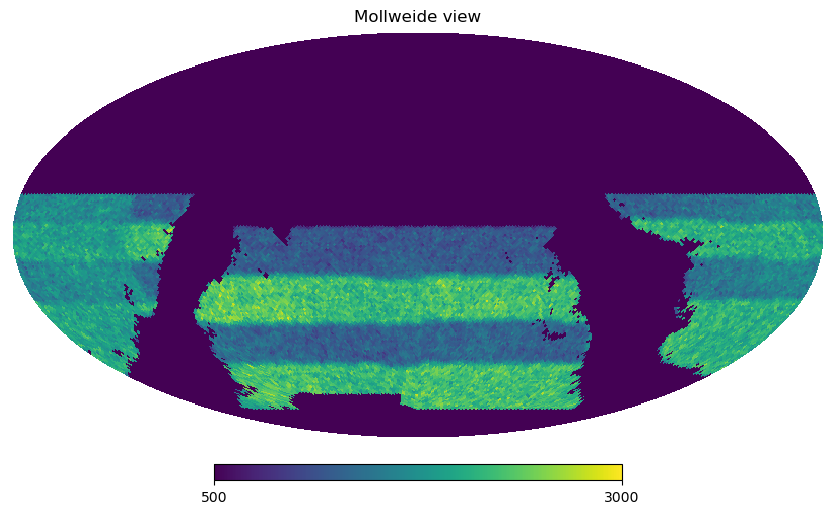

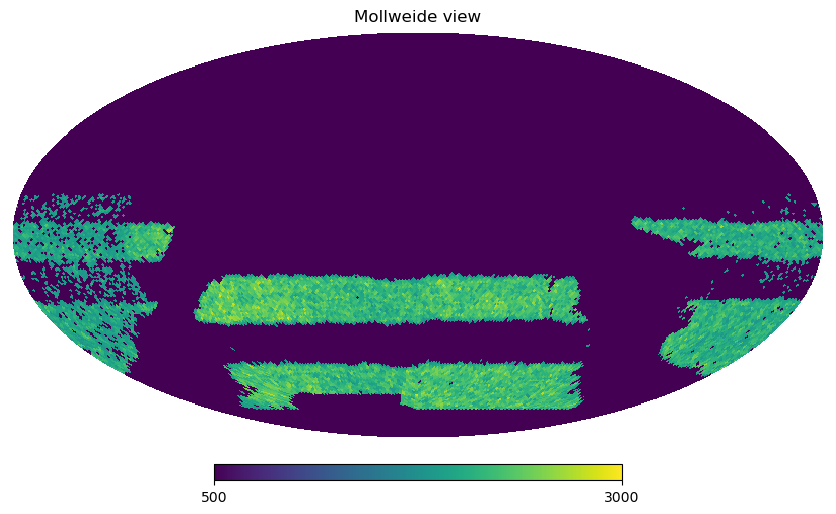

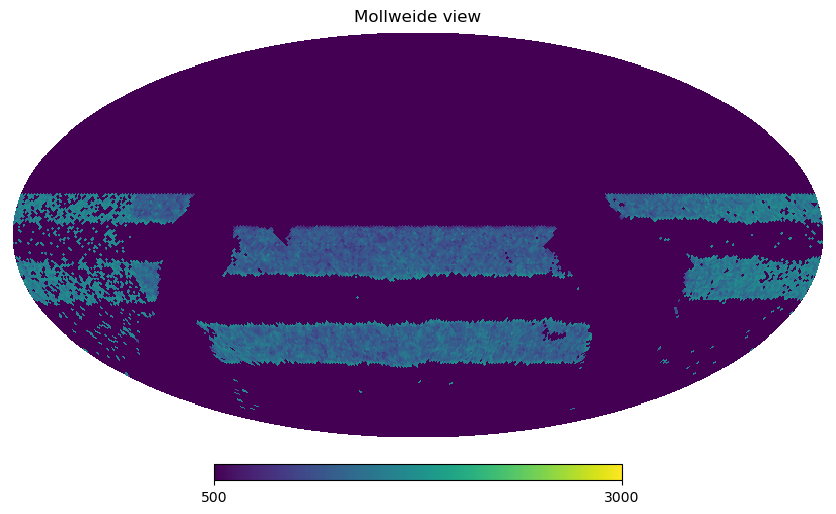

In [93]:
show_clusters(map1, labels)

While these clusters aren't exactly what we want (there are a few places where it doesn't recognize interleaved stripes), it seems like a promising starting point.

Since the areas are 52% and 48%, presumably we would identify the larger region as the one we'd keep, though they are close in area so it could be it's worth keeping a smaller but deeper one in some cases.  The two regions have different median values of total exposure time by 60%.


In [49]:
# Let's check the declination histograms for the "middle" bit, to see if the stripes are clear 
# (and then not clear in other cases like noroll)
def dec_hist(map, labels, maskval=0):
    """A utility to look at the Declination histogram for a particular RA range to see if there is structure."""
    theta, phi = hp.pixelfunc.pix2ang(nside, ipix=np.arange(hp.nside2npix(nside)))
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    
    cutval = maskval+0.1
    # Identify a usable RA range and also select only unmasked pixels
    ra_lower = 100
    ra_upper = 275
    cond = ((ra<ra_lower) | (ra>ra_upper)) & (map1 > cutval)
    expanded_labels = expand_labels(map, labels)
    cond1 = cond & (expanded_labels==1)
    cond2 = cond & (expanded_labels==2)
    
    # Set up histogram
    min_dec = -90
    max_dec = 10
    delta_dec = 4
    n_bins_dec = (max_dec-min_dec)/delta_dec
    dec_bins = np.linspace(min_dec, max_dec, int(n_bins_dec+1))
    
    # Make the plot:
    plt.hist(dec[cond], bins=dec_bins, label='Original strategy', histtype='step')
    plt.hist(dec[cond1], bins=dec_bins, label='Cluster 1', histtype='step')
    plt.hist(dec[cond2], bins=dec_bins, label='Cluster 2', histtype='step')
    plt.xlabel('Declination (degrees)')
    plt.ylabel('Number of Healpix pixels')
    plt.title('RA < %.1f or RA > %.1f region'%(ra_lower, ra_upper))
    plt.legend()
    
    # Do a KS test and report results
    from scipy.stats import kstest as KStest
    print('KS test for cluster 1:',KStest(dec[cond], dec[cond1]))
    print('KS test for cluster 2:',KStest(dec[cond], dec[cond2]))

KS test for cluster 1: KstestResult(statistic=0.26252839065541855, pvalue=6.478453250504392e-220, statistic_location=-15.094787099543193, statistic_sign=-1)
KS test for cluster 2: KstestResult(statistic=0.2477380587875076, pvalue=3.251054344581575e-203, statistic_location=-15.094787099543193, statistic_sign=1)


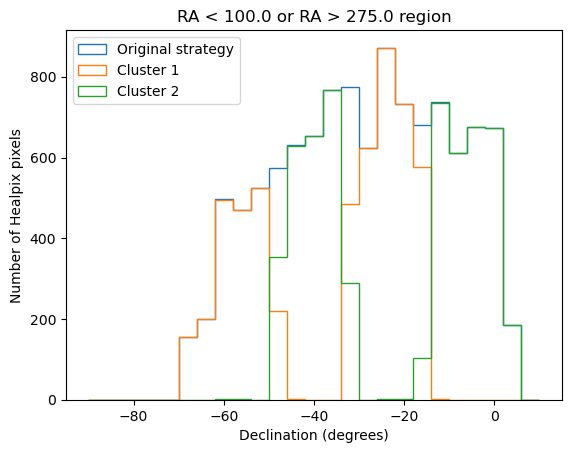

In [50]:
dec_hist(map1, labels)

The stripiness of rolling is very apparent here and the KS test says that the overall distribution and that of one of the clusters are completely inconsistent.

We also want to get sensible results if we run the metric on datasets that don't show as much structure as baseline at year 3.  In particular, we'd like it to recognize relatively homogeneous datasets (at the level of `noroll`) by putting most of the dataset into one cluster and noting that the medians are not that different.

Fraction of area in cluster 1: 0.576415
Median value for cluster 1: 1830.000000
Fraction of area in cluster 2: 0.423585
Median value for cluster 2: 1650.000000


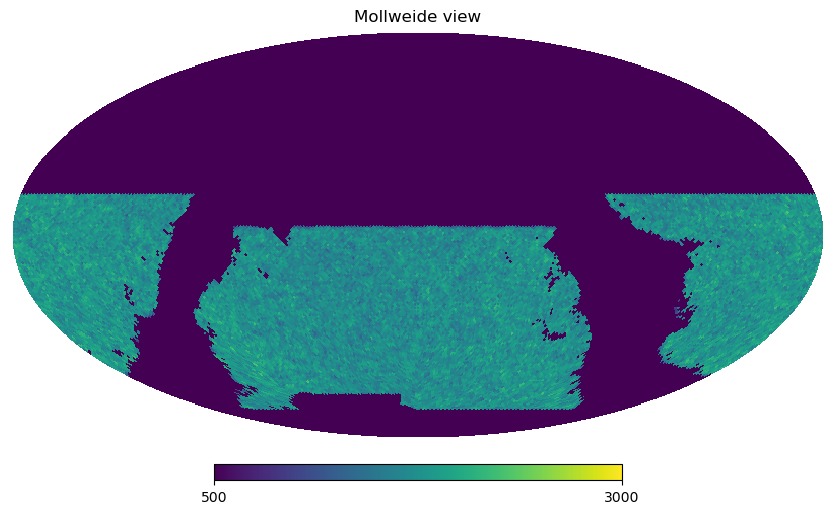

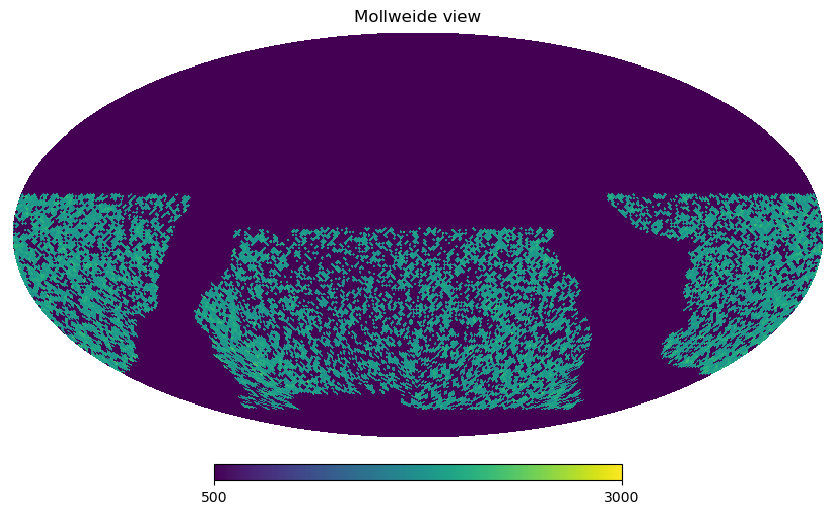

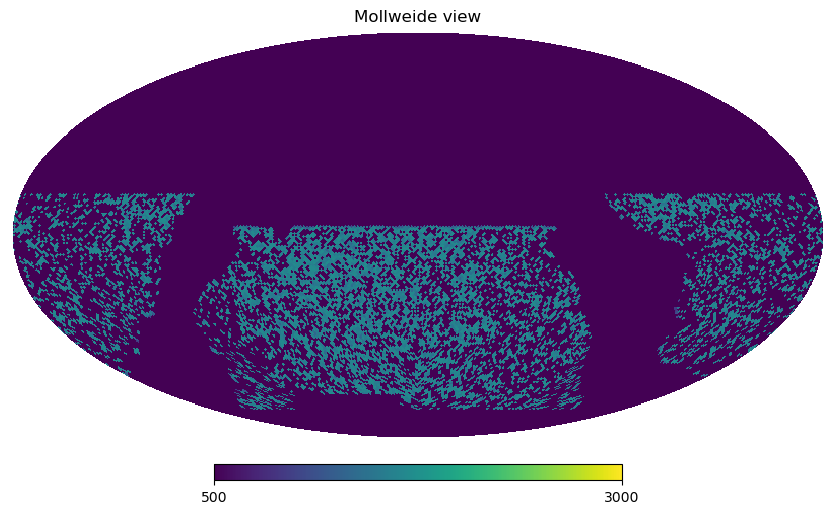

In [51]:
# Let's see what happens when we try this with noroll -- does it recognize there isn't as much structure?
clustering_data = make_clustering_dataset(map2)
labels2 = apply_clustering(clustering_data)
show_clusters(map2, labels2)

Here the "clusters" are spread all over the place, and the difference in median value of exposure time is only 10% rather than 60%.  Presumably, our area-at-risk metric could have a threshold in median value of exposure time -- i.e., if the difference for the clusters is small enough (like 10%) then they aren't particularly interesting, and we would default to 0% of area at risk.  It could also look for structure in declination values, as a way to check whether there is stripiness in the clusters.

KS test for cluster 1: KstestResult(statistic=0.04767141737112157, pvalue=8.888873825731161e-08, statistic_location=-25.944479772370013, statistic_sign=-1)
KS test for cluster 2: KstestResult(statistic=0.04909130514720578, pvalue=4.5220675769873524e-08, statistic_location=-25.944479772370013, statistic_sign=1)


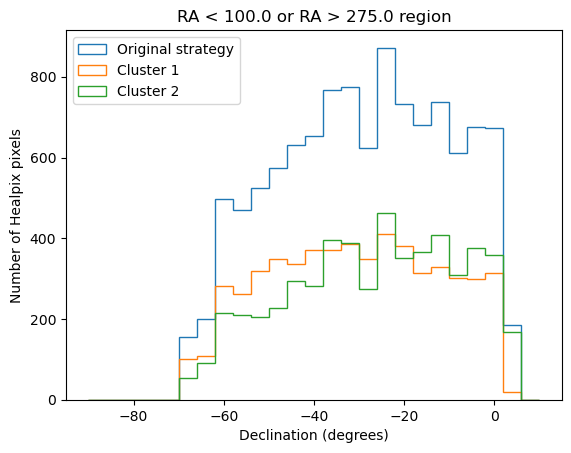

In [52]:
# Now let's try the dec histogram trick and KS test.
dec_hist(map2, labels2)

Formally these Dec histograms are inconsistent with flat.  However, there are a large number of data points, and the discrepancy is considerably less than before.  The KS statistic has doubled compared to the baseline.

Now let's try to run the FoM metric on baseline v3 in its entirety; on the two chunks separately; and on noroll.

In [94]:
def show_fom(bd):
    print(bd[list(bd.keys())[0]].summary_values['3x2ptFoM'])
    
def return_fom(bd):
    return bd[list(bd.keys())[0]].summary_values['3x2ptFoM']

In [96]:
expanded_labels = expand_labels(map1, labels)
my_hpid_1 = np.where(expanded_labels == 1)[0]
my_hpid_2 = np.where(expanded_labels == 2)[0]
bgroup, bd = mzmod.get_3x2pt_metric(v33_name_list[0], v33_sim_list[0], year=3, my_hpid=None)
print('Year 3, baseline, no cuts')
show_fom(bd)
bgroup, bd = mzmod.get_3x2pt_metric(v33_name_list[0], v33_sim_list[0], year=3, my_hpid=my_hpid_1)
print('Year 3, baseline, cluster 1')
show_fom(bd)
bgroup, bd = mzmod.get_3x2pt_metric(v33_name_list[0], v33_sim_list[0], year=3, my_hpid=my_hpid_2)
print('Year 3, baseline, cluster 2')
show_fom(bd)
bgroup, bd = mzmod.get_3x2pt_metric(v33_name_list[1], v33_sim_list[1], year=3, my_hpid=None)
print('Year 3, noroll')
show_fom(bd)


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Year 3, baseline, no cuts
37.0275116260394
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Year 3, baseline, cluster 1
24.68871224783607
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Year 3, baseline, cluster 2
23.321104542922992
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Year 3, noroll
37.25228168763351


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


We can see that the 3x2pt FoM is significantly lower for the clusters than for the full survey, because we chose a strategy and year with significant impacts of rolling.

What's above is very promising, so let's string it together into a metric that we'll call UniformAreaFoMFraction:

1. Obtain the exposure time map for the given strategy and year.
2. Check for bimodality of the depth distribution.
3. If no, return 1 (i.e. we don't need to remove area and lose constraining power)
4. If yes, execute the clustering algorithm.  Do a sanity check that the clusters have substantively different median exposure times.  (If no, return 1.  If yes, continue to step 5.)
5. Return the FoM with those cuts to limit to one of the regions, divided by the original FoM before these cuts.

This metric is defined so that "1" means no cuts and less than one means we've cut the area.  It's defined with reference to itself rather than with reference to e.g. some idealized no-roll case, but we could reconsider this.

We'll have a keyword argument that controls the verbosity, so we can get intermediate diagnostic outputs.

For now this is simply written as a python function, but it should be mappable onto a summary metric in MAF.

In [182]:
# Utility routines to check for bimodality of depth maps
def double_gauss(x, *args):
    # Convenience function for fitting to a sum of Gaussians.
    m1, m2, s1, s2, k1, k2 = args
    ret = k1*scipy.stats.norm.pdf(x, loc=m1 ,scale=s1)
    ret += k2*scipy.stats.norm.pdf(x, loc=m2 ,scale=s2)
    return ret

def single_gauss(x, *args):
    # Convenience function for fitting to a sum of Gaussians.
    m1, s1, k1 = args
    ret = k1*scipy.stats.norm.pdf(x, loc=m1 ,scale=s1)
    return ret

def fit_exptime_dist(map, maskval=0):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cutval = maskval + 0.1
    mapvals_use = map[map>cutval]
    params_single = [np.median(mapvals_use), np.std(mapvals_use), 1]
    params_double = [np.median(mapvals_use)-2*np.std(mapvals_use), np.median(mapvals_use)+2*np.std(mapvals_use),
                     np.std(mapvals_use), np.std(mapvals_use), 0.5, 0.5]
    counts, bins, _ = plt.hist(map[map>0], density=True, bins=40, label='histogram')
    bin_mids = 0.5*(bins[1:] + bins[:-1])
    plt.xlabel('RIZ exposure time')

    # Fitting
    fitted_params_double, cov_double = scipy.optimize.curve_fit(double_gauss, bin_mids, counts, p0=params_double)
    fitted_params_single, cov_single = scipy.optimize.curve_fit(single_gauss, bin_mids, counts, p0=params_single)
    plt.plot(bin_mids, double_gauss(bin_mids, *fitted_params_double), label='double Gaussian fit')
    plt.plot(bin_mids, single_gauss(bin_mids, *fitted_params_single), label='single Gaussian fit')
    chi2_double = np.sum((counts-double_gauss(bin_mids, *fitted_params_double))**2)
    chi2_single = np.sum((counts-single_gauss(bin_mids, *fitted_params_single))**2)
    #print('Double Gaussian params, chi2:', *fitted_params_double, chi2_double)
    #print('Single Gaussian params, chi2:', *fitted_params_single, chi2_single)
    #print('chi2 ratio:', chi2_double/chi2_single)
    if fitted_params_double[5] < fitted_params_double[4]:
        dratio = fitted_params_double[5]/fitted_params_double[4]
    else:
        dratio = fitted_params_double[4]/fitted_params_double[5]
    #print('Double Gaussian ratio:', dratio)
    plt.legend()
    return chi2_double/chi2_single, dratio

def bimodality_test(map, verbose=False, chi2_ratio_thres = 0.9, dratio_thres=0.1):
    chi2_ratio, dratio = fit_exptime_dist(map)
    if verbose: print("Verbose bimodality test: %f %f %f %f"%(chi2_ratio, chi2_ratio_thres, dratio, dratio_thres))
    if chi2_ratio < chi2_ratio_thres and dratio > dratio_thres:
        return True
    else:
        return False

In [188]:
def UniformAreaFoMFraction(use_run_name, use_opsim_fname, year=10, nside=64, verbose=True):
    """Docstrings go here :)"""
    # Stage one: get the exposure time map for the given strategy, year.
    # When integrating into MAF will have to not use our custom routine; code will become simpler (need to test that here).
    if verbose: print("Getting exposure time map for this strategy, year, and nside:", use_run_name,
                     use_opsim_fname, year)
    _, _, map = mzmod.metric_plots(use_run_name, use_opsim_fname, use_metric=maf.RIZDetectionCoaddExposureTime(), year=year, nside=nside, return_map=True)

    if verbose:
        # Define a set of histogram bins
        print("Verbose mode - histogram of exposure times for unmasked region")
        min_t, max_t = np.percentile(map[map>0], (5,95))
        n_bins = 25
        bins = np.linspace(min_t, max_t, int(n_bins+1))
        plt.hist(map[map>0], bins=bins, density=True, histtype='step')
        plt.xlabel('RIZ cumulative exposure time')

    # Stage 2: Check for bimodality
    is_bimodal = bimodality_test(map, verbose)
    # Stage 3: First decision point
    if not is_bimodal:
        if verbose:
            print("Verbose mode - histogram of exposure times is not bimodal!  Returning 1")
        return 1
    else:
        # Stage 4: do the clustering
        if verbose: print("Carrying out the clustering exercise for this map")
        clustering_data = make_clustering_dataset(map)
        labels = apply_clustering(clustering_data)

        area_frac, med_val = get_area_stats(map, labels)
        if verbose:
            print("Verbose mode - showing original map and clusters identified for this map")
            show_clusters(map, labels)
            print("Area fractions", area_frac)
            print("Median exposure time values", med_val)
            print("Median exposure time ratio", np.max(med_val)/np.min(med_val))

        # One more "out" as occasionally the bimodality test fails:
        if np.max(med_val)/np.min(med_val) < 1.2:
            if verbose: print("Verbose mode - the clusters have too-similar median exposure times")
            return 1
        else:
            # Stage 5: Get the FoM without/with cuts.  We want to check the FoM for each area, if we're doing cuts, and 
            # return the higher one. This will typically be for the larger area, but not necessarily, if the smaller area
            # is deeper.
            expanded_labels = expand_labels(map, labels)
            my_hpid_1 = np.where(labels == 1)[0]
            my_hpid_2 = np.where(labels == 2)[0]
            bgroup1, bd1 = mzmod.get_3x2pt_metric(use_run_name, use_opsim_fname, year=year, my_hpid=my_hpid_1)
            fom1 = return_fom(bd1)
            bgroup2, bd2 = mzmod.get_3x2pt_metric(use_run_name, use_opsim_fname, year=year, my_hpid=my_hpid_2)
            fom2 = return_fom(bd2)
            fom = np.max((fom1, fom2))
            if verbose:
                print("Verbose mode - select which area to report the FoM for", fom1, fom2, fom)
            bgroup, bd = mzmod.get_3x2pt_metric(use_run_name, use_opsim_fname, year=year, my_hpid=None)
            fom_total = return_fom(bd)
            if verbose:
                print("Verbose mode - original (uncut) FoM", fom_total)
                print("Verbose mode - FoM ratio", fom/fom_total)
            return fom/fom_total


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


1

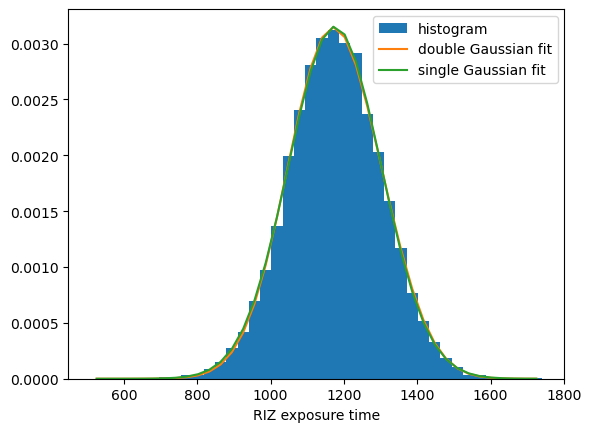

In [189]:
UniformAreaFoMFraction(v33_name_list[1], v33_sim_list[1], year=2, verbose=False)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


1 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


2 0.6865374759597279
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


3 0.6587217221330925
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


4 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


5 0.6343942833523605
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


6 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


7 0.6236583454796755
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


8 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


9 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


10 1


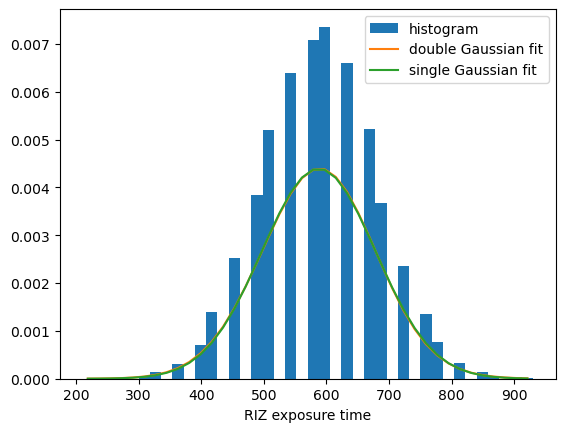

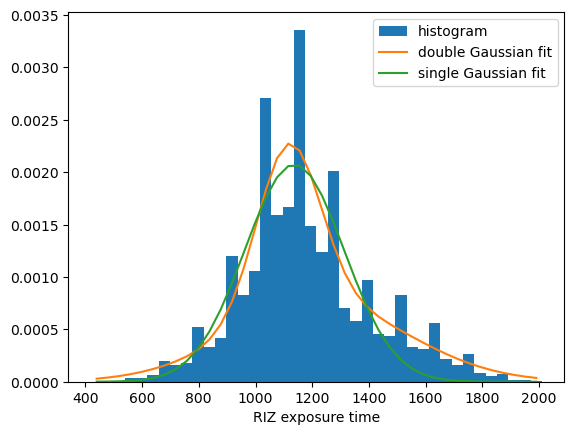

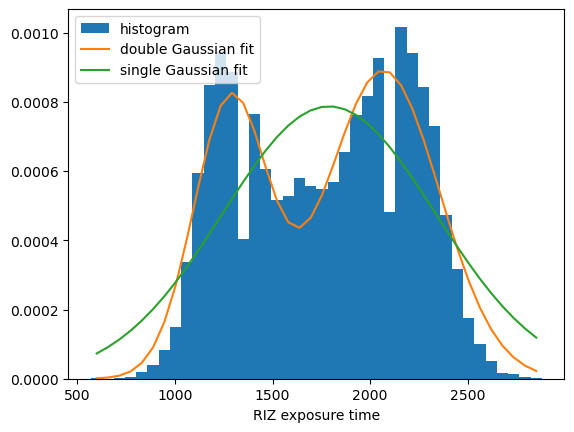

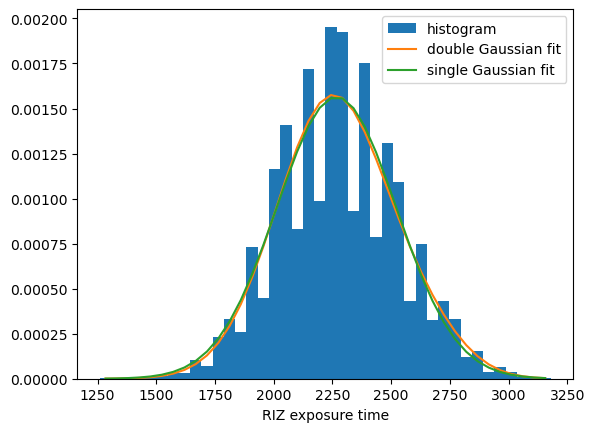

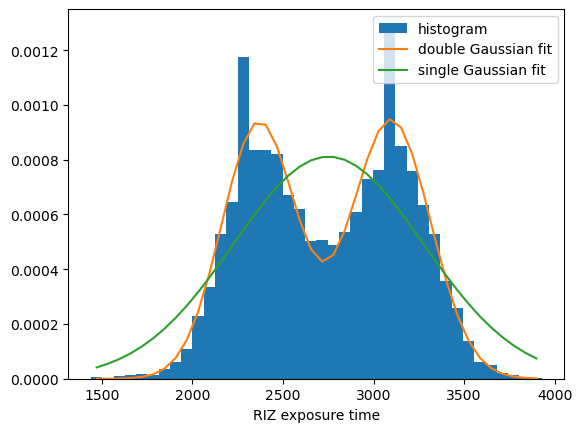

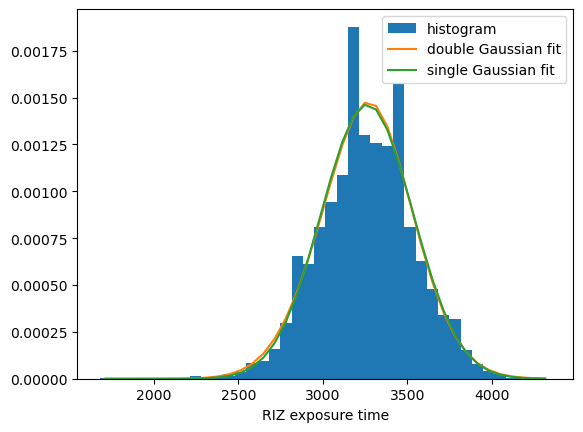

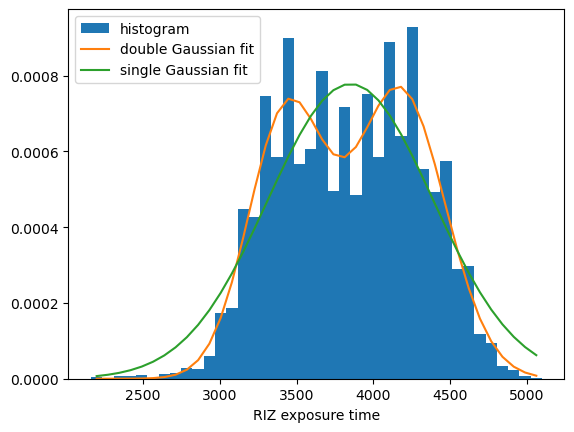

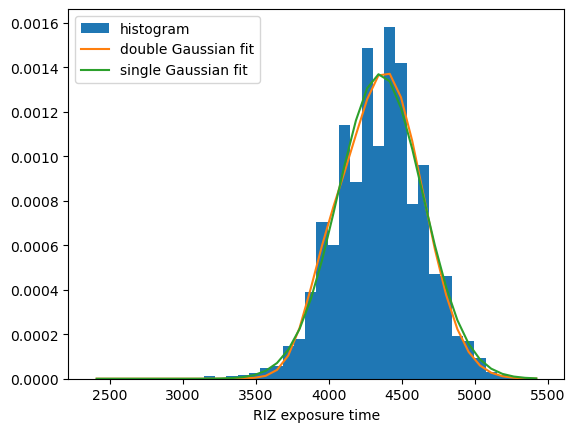

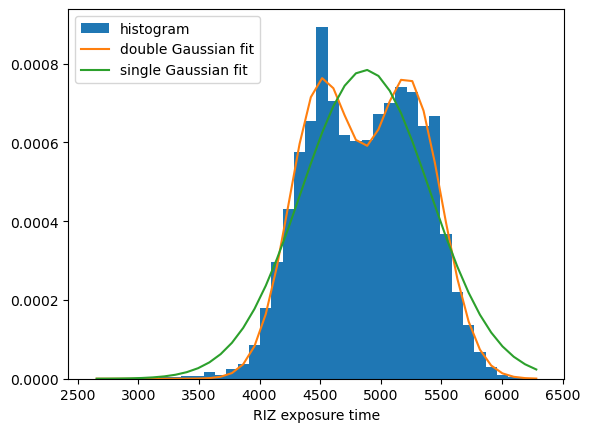

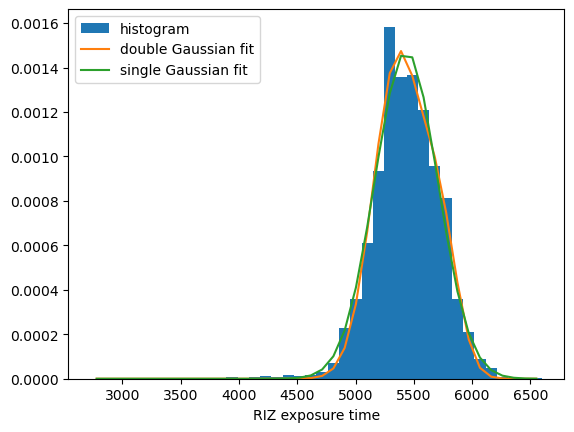

In [190]:
# Do this for baseline in each year.
baseline_year_list = []
baseline_frac_list = []
for year in range(1,11):
    frac = UniformAreaFoMFraction(v33_name_list[0], v33_sim_list[0], year=year, verbose=False)
    print(year, frac)
    baseline_year_list.append(year)
    baseline_frac_list.append(frac)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


1 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


2 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


3 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


4 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


5 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


6 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


7 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


8 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


9 1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:44: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


10 1


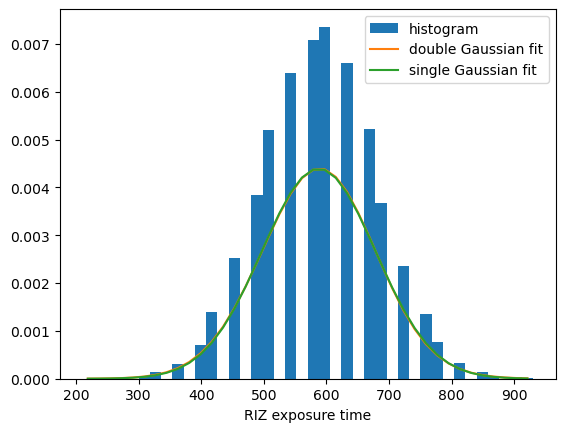

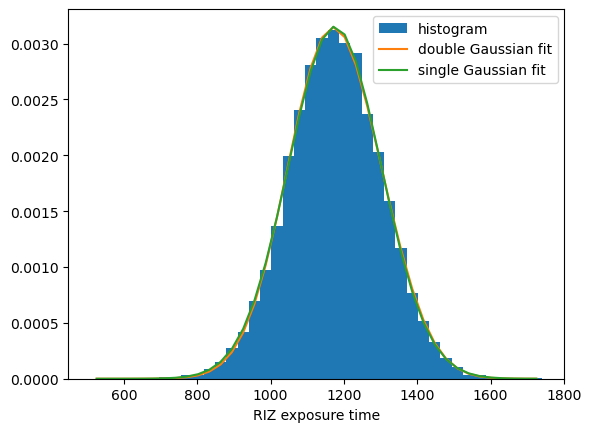

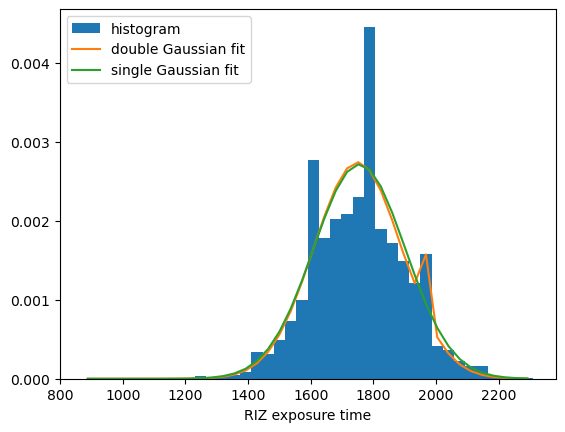

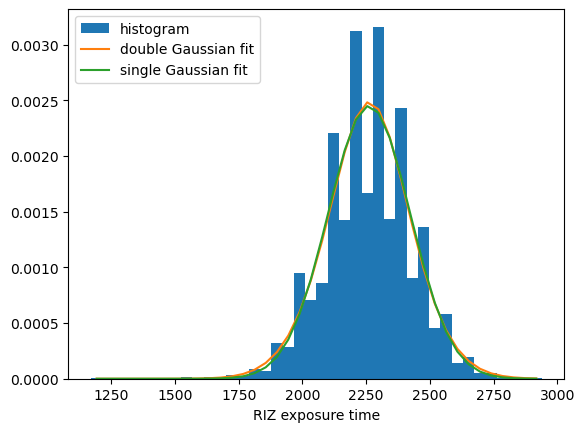

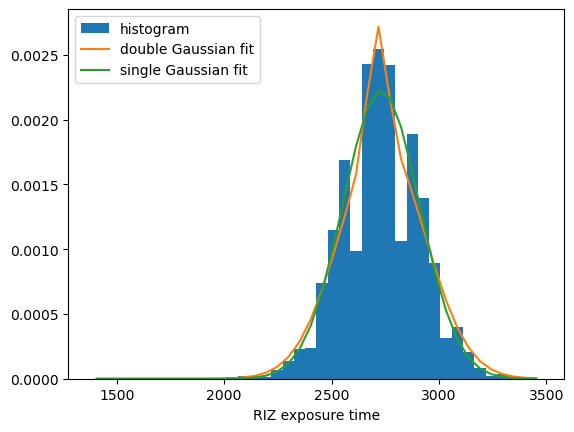

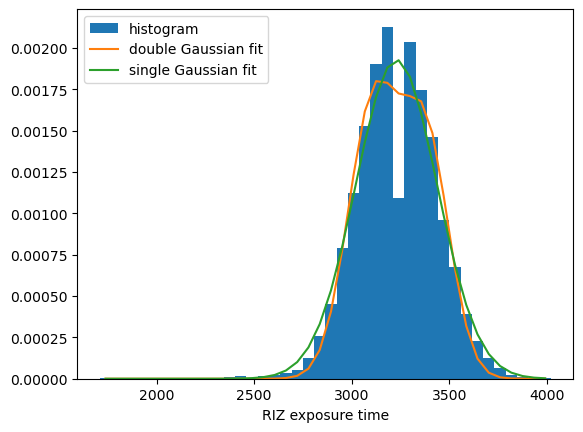

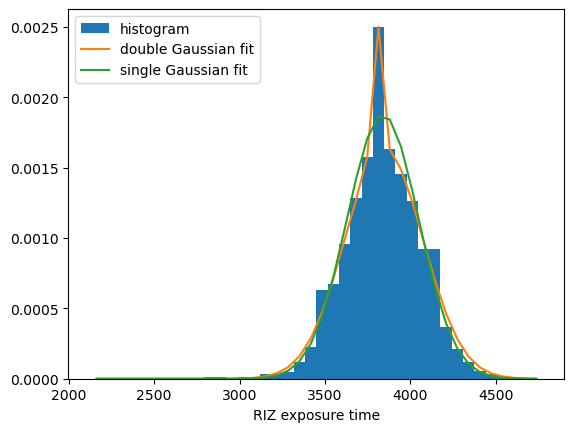

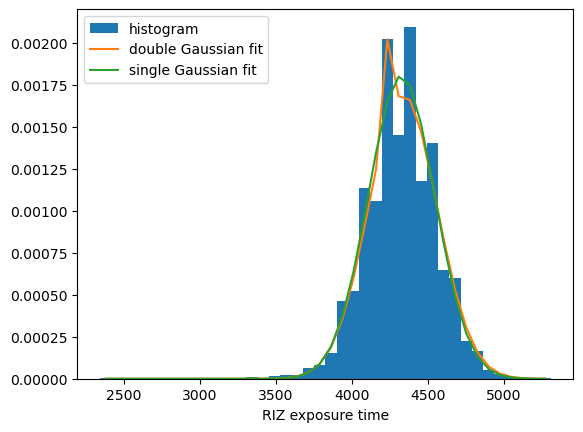

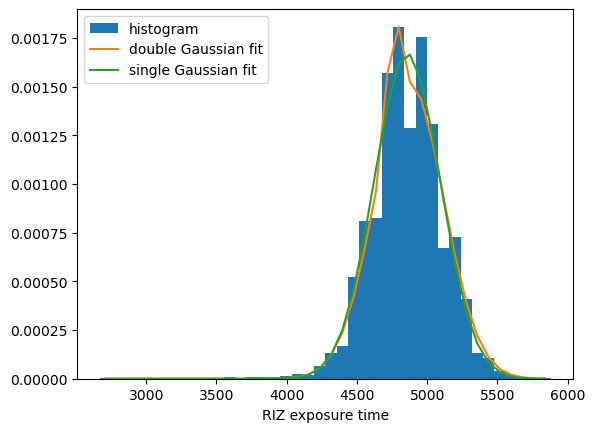

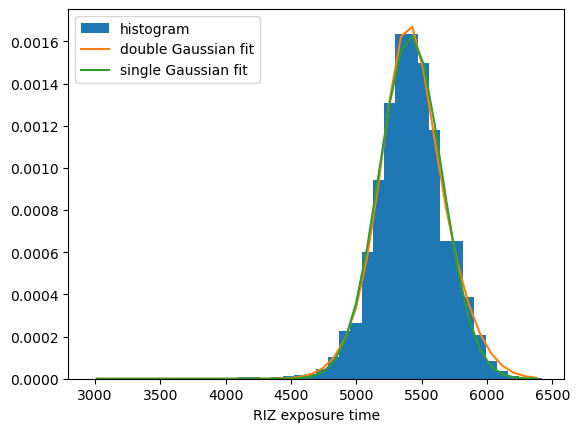

In [191]:
# Do this for noroll in each year.
noroll_year_list = []
noroll_frac_list = []
for year in range(1,11):
    frac = UniformAreaFoMFraction(v33_name_list[1], v33_sim_list[1], year=year, verbose=False)
    print(year, frac)
    noroll_year_list.append(year)
    noroll_frac_list.append(frac)

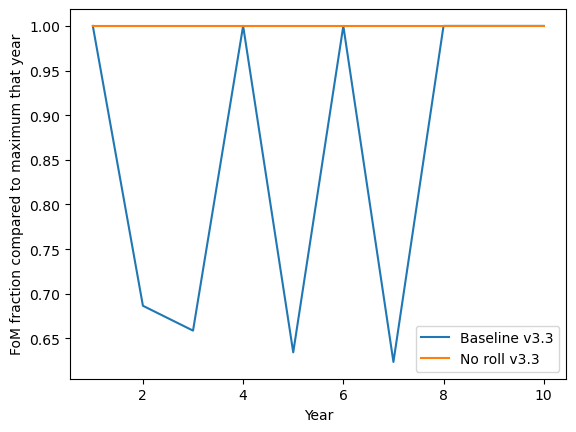

In [192]:
plt.plot(baseline_year_list, baseline_frac_list, label='Baseline v3.3')
plt.plot(noroll_year_list, noroll_frac_list, label='No roll v3.3')
plt.xlabel('Year')
plt.ylabel('FoM fraction compared to maximum that year')
plt.legend()